# Proyek Akhir : Image Classification Model Deployment

## Siswa: Hanzalah Assidiq

Dataset: kaggle datasets download -d muratkokludataset/pistachio-image-dataset

## Import Libraries

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import pathlib
import zipfile,os

## Extact file zip dan melakukan splitfolder

In [9]:
local_zip = '/tmp/PistachioImageDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [13]:
splitfolders.ratio('/tmp/Pistachio_Image_Dataset/Split', output='/tmp/Pistachio_Image_Dataset/Split', seed=1337, ratio=(.8, .2))
base_dir = '/tmp/Pistachio_Image_Dataset/Split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 2148 files [00:00, 3306.41 files/s]


## Melakukan Images Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
                    rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size=(150, 150), 
        batch_size=32, 
        class_mode='binary')

Found 1717 images belonging to 2 classes.
Found 431 images belonging to 2 classes.


## Pemodelan

In [21]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150, 150, 3)),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')                         
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

### Penggunaan Callbacks

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nSelamat akurasi model telah mencapai > 85% !")
      self.model.stop_training = True
callbacks = myCallback()

## Model Fitting

In [26]:
hist = model.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=25,
      validation_data=validation_generator,
      validation_steps=5,  
      verbose=2,
      callbacks=[callbacks])

Epoch 1/25
25/25 - 8s - loss: 0.3831 - accuracy: 0.8200 - val_loss: 0.4551 - val_accuracy: 0.8000 - 8s/epoch - 318ms/step
Epoch 2/25
25/25 - 8s - loss: 0.3760 - accuracy: 0.8264 - val_loss: 0.4674 - val_accuracy: 0.8062 - 8s/epoch - 313ms/step
Epoch 3/25
25/25 - 8s - loss: 0.3707 - accuracy: 0.8350 - val_loss: 0.3891 - val_accuracy: 0.8313 - 8s/epoch - 310ms/step
Epoch 4/25
25/25 - 8s - loss: 0.3751 - accuracy: 0.8403 - val_loss: 0.3699 - val_accuracy: 0.8438 - 8s/epoch - 307ms/step
Epoch 5/25
25/25 - 8s - loss: 0.4005 - accuracy: 0.8100 - val_loss: 0.3696 - val_accuracy: 0.8250 - 8s/epoch - 315ms/step
Epoch 6/25
25/25 - 8s - loss: 0.4162 - accuracy: 0.8225 - val_loss: 0.3673 - val_accuracy: 0.8000 - 8s/epoch - 316ms/step
Epoch 7/25
25/25 - 8s - loss: 0.3848 - accuracy: 0.8340 - val_loss: 0.3480 - val_accuracy: 0.8438 - 8s/epoch - 306ms/step
Epoch 8/25
25/25 - 9s - loss: 0.3724 - accuracy: 0.8390 - val_loss: 0.3691 - val_accuracy: 0.8125 - 9s/epoch - 360ms/step
Epoch 9/25
25/25 - 8s - 

## Membuat plot akurasi dan loss

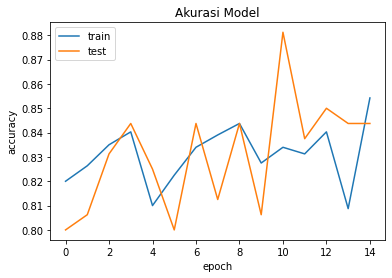

In [29]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

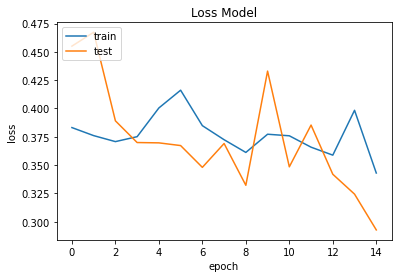

In [28]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Menyimpan model dalam format TF-Lite

In [30]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

76140764